In [1]:
import glob
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from torchvision.utils import make_grid, save_image

Preprocessing DATA

In [2]:
def show_img(img_tensor, nrow=5, title=""):
    img_tensor = img_tensor.detach().cpu()*0.5 + 0.5
    img_grid = make_grid(img_tensor, nrow=nrow).permute(1, 2, 0)
    plt.figure(figsize=(18, 8))
    plt.imshow(img_grid)
    plt.axis("off")
    plt.title(title)
    plt.show()

Data augment

In [3]:
class CustomRotation(object):
    def __call__(self, x):
        angle = np.random.choice([0., 90, 180, 270])
        return transforms.functional.rotate(x, angle)

class CustomTransform(object):
    def __init__(self, load_dim=286, target_dim=256):
        self.transform = transforms.Compose([
            transforms.Resize((load_dim, load_dim)),
            transforms.RandomCrop((target_dim, target_dim)),
            CustomRotation(),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.5),
        ])
        
    def __call__(self, img, stage="fit"):
        if stage == "fit":
            img = self.transform(img)
        return img/127.5 - 1

In [4]:
class CustomDataset(Dataset):
    def __init__(self, monet_filenames, photo_filenames, transform, stage):
        self.photo_filenames = photo_filenames
        self.transform = transform
        self.stage = stage
        if stage == "fit":
            self.monet_filenames = monet_filenames
            self.check = len(monet_filenames)>len(photo_filenames)
            self.shuffle()
            
    def shuffle(self):
        if self.check:
            self.indices = torch.randperm(len(self.monet_filenames))[:len(self.photo_filenames)]
            
        else:
            self.indices = torch.randperm(len(self.photo_filenames))[:len(self.monet_filenames)]
        
    def __len__(self):
        if self.stage == "fit":
            return min(
                len(self.monet_filenames), len(self.photo_filenames),
            )
    
        elif self.stage == "predict":
            return len(self.photo_filenames)
    
    def __getitem__(self, idx):
        if self.stage == "fit":
            monet_idx = self.indices[idx] if self.check else idx
            photo_idx = idx if self.check else self.indices[idx]
            monet_name = self.monet_filenames[monet_idx]
            photo_name = self.photo_filenames[photo_idx]
            monet = read_image(monet_name)
            photo = read_image(photo_name)
            if idx == len(self)-1:
                self.shuffle()
            return self.transform(monet), self.transform(photo)
    
        elif self.stage == "predict":
            photo_name = self.photo_filenames[idx]
            photo = read_image(photo_name)
            return self.transform(photo, stage=self.stage)

In [5]:
MONET_DIR = "/kaggle/input/gan-getting-started/monet_jpg/*.jpg"
PHOTO_DIR = "/kaggle/input/gan-getting-started/photo_jpg/*.jpg"
BATCH_SIZE = 1
transform = CustomTransform()

In [6]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(
        self, 
        monet_dir=MONET_DIR,
        photo_dir=PHOTO_DIR,
        batch_size=BATCH_SIZE,
        transform=transform,
    ):
        super().__init__()
        self.monet_filenames = sorted(glob.glob(monet_dir))
        self.photo_filenames = sorted(glob.glob(photo_dir))
        self.batch_size = batch_size
        self.transform = transform
        
    def setup(self, stage):
        if stage == "fit":
            self.train = CustomDataset(
                monet_filenames=self.monet_filenames,
                photo_filenames=self.photo_filenames,
                transform=self.transform,
                stage=stage,
            )
        
        elif stage == "predict":
            self.predict = CustomDataset(
                monet_filenames=self.monet_filenames,
                photo_filenames=self.photo_filenames,
                transform=self.transform,
                stage=stage,
            )
            
    def train_dataloader(self):
        return DataLoader(
            self.train, 
            batch_size=self.batch_size,
            shuffle=True,
        )
    
    def predict_dataloader(self):
        return DataLoader(
            self.predict, 
            batch_size=self.batch_size,
            shuffle=False,
        )

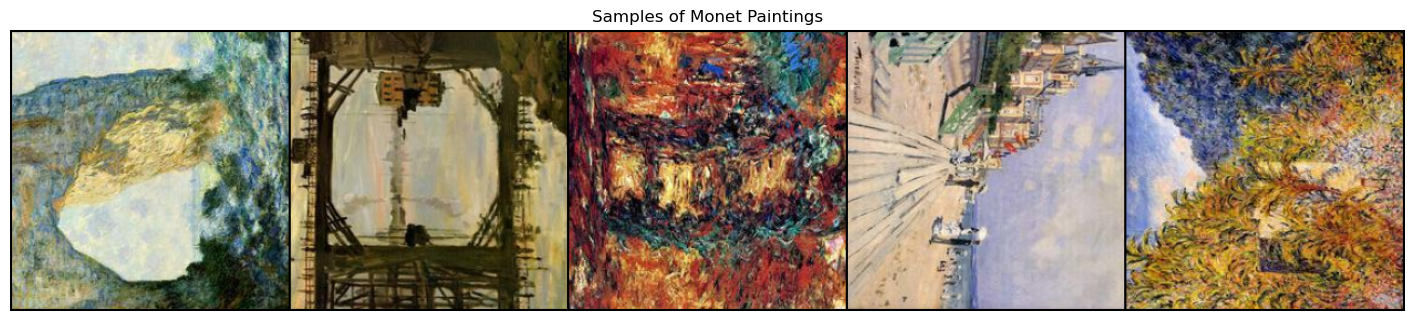

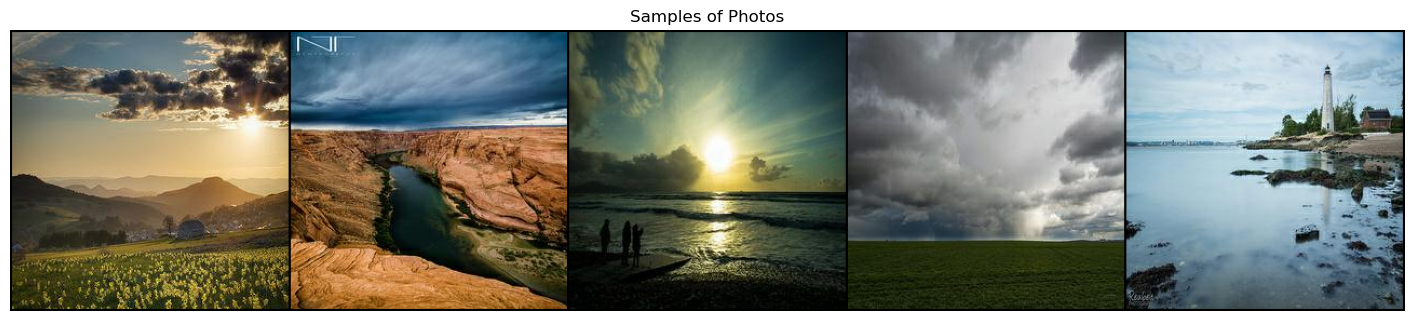

In [7]:
dm_sample = CustomDataModule(batch_size=5)
dm_sample.setup("fit")
dm_sample.setup("predict")

train_loader = dm_sample.train_dataloader()
monet_samples, _ = next(iter(train_loader))

predict_loader = dm_sample.predict_dataloader()
photo_samples = next(iter(predict_loader))

show_img(monet_samples, title="Samples of Monet Paintings")
show_img(photo_samples, title="Samples of Photos")

In [8]:
class Downsampling(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        norm=True,
        kernel_size=4,
        stride=2,
        padding=1,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                      stride=stride, padding=padding, bias=False)
        )
        if norm:
            self.block.append(nn.InstanceNorm2d(out_channels, affine=True))
        self.block.append(nn.LeakyReLU(0.3))
        
    def forward(self, x):
        return self.block(x)

In [9]:
class Upsampling(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        dropout=False,
        kernel_size=4,
        stride=2,
        padding=1,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
        )
        if dropout:
            self.block.append(nn.Dropout(0.5))
        self.block.append(nn.ReLU())
        
    def forward(self, x):
        return self.block(x)

In [10]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, hid_channels):
        super().__init__()
        self.downsampling_blocks = nn.Sequential(
            Downsampling(in_channels, hid_channels, norm=False), #64x128x128
            Downsampling(hid_channels, hid_channels*2), #128x64x64
            Downsampling(hid_channels*2, hid_channels*4), #256x32x32
            Downsampling(hid_channels*4, hid_channels*8), #512x16x16
            Downsampling(hid_channels*8, hid_channels*8), #512x8x8
            Downsampling(hid_channels*8, hid_channels*8), #512x4x4
            Downsampling(hid_channels*8, hid_channels*8), #512x2x2
            Downsampling(hid_channels*8, hid_channels*8, norm=False), #512x1x1
        )
        self.upsampling_blocks = nn.Sequential(
            Upsampling(hid_channels*8, hid_channels*8, dropout=True), #(512+512)x2x2
            Upsampling(hid_channels*16, hid_channels*8, dropout=True), #(512+512)x4x4
            Upsampling(hid_channels*16, hid_channels*8, dropout=True), #(512+512)x8x8
            Upsampling(hid_channels*16, hid_channels*8), #(512+512)x16x16
            Upsampling(hid_channels*16, hid_channels*4), #(256+256)x32x32
            Upsampling(hid_channels*8, hid_channels*2), #(128+128)x64x64
            Upsampling(hid_channels*4, hid_channels), #(64+64)x128x128
        )
        self.feature_block = nn.Sequential(
            nn.ConvTranspose2d(hid_channels*2, out_channels,
                               kernel_size=4, stride=2, padding=1), #3x256x256
            nn.Tanh(),
        )
        
    def forward(self, x):
        skips = []
        for down in self.downsampling_blocks:
            x = down(x)
            skips.append(x)
            
        skips = reversed(skips[:-1])
        for up, skip in zip(self.upsampling_blocks, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)

        return self.feature_block(x)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, hid_channels):
        super().__init__()
        self.block = nn.Sequential(
            Downsampling(in_channels, hid_channels, norm=False), #64x128x128
            Downsampling(hid_channels, hid_channels*2), #128x64x64
            Downsampling(hid_channels*2, hid_channels*4), #256x32x32
            Downsampling(hid_channels*4, hid_channels*8, stride=1), #512x31x31
            nn.Conv2d(hid_channels*8, 1, kernel_size=4, padding=1), #1x30x30
        )
        
    def forward(self, x):
        return self.block(x)

In [12]:
IN_CHANNELS = 3
OUT_CHANNELS = 3
HID_CHANNELS = 64
LR = 2e-4
BETAS = (0.5, 0.999)
LAMBDA = 10
NUM_EPOCHS = 10
DISPLAY_EPOCHS = 30

In [13]:
class CycleGAN(pl.LightningModule):
    def __init__(
        self, 
        in_channels=IN_CHANNELS,
        out_channels=OUT_CHANNELS, 
        hid_channels=HID_CHANNELS,
        lr=LR,
        betas=BETAS,
        lambda_w=LAMBDA,
        display_epochs=DISPLAY_EPOCHS,
        photo_samples=photo_samples,
    ):
        super().__init__()
        self.lr = lr
        self.betas = betas
        self.lambda_w = lambda_w
        self.display_epochs = display_epochs
        self.photo_samples = photo_samples
        self.loss_history = []
        self.epoch_count = 0
        
        self.gen_PM = Generator(in_channels, out_channels, hid_channels).apply(self.weights_init)
        self.gen_MP = Generator(in_channels, out_channels, hid_channels).apply(self.weights_init)
        self.disc_M = Discriminator(in_channels, hid_channels).apply(self.weights_init)
        self.disc_P = Discriminator(in_channels, hid_channels).apply(self.weights_init)
        
    def forward(self, z):
        return self.gen_PM(z)
    
    def weights_init(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.InstanceNorm2d)):
            nn.init.normal_(m.weight, 0., 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.)
    
    def adv_criterion(self, y_hat, y):
        return F.binary_cross_entropy_with_logits(y_hat, y)
    
    def recon_criterion(self, y_hat, y):
        return F.l1_loss(y_hat, y)
    
    def adv_loss(self, real_X, disc_Y, gen_XY):
        fake_Y = gen_XY(real_X)
        disc_fake_Y_hat = disc_Y(fake_Y)
        adv_loss_XY = self.adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat))
        return adv_loss_XY, fake_Y
    
    def id_loss(self, real_X, gen_YX):
        id_X = gen_YX(real_X)
        id_loss_X = self.recon_criterion(id_X, real_X)
        return id_loss_X
    
    def cycle_loss(self, real_X, fake_Y, gen_YX):
        cycle_X = gen_YX(fake_Y)
        cycle_loss_X = self.recon_criterion(cycle_X, real_X)
        return cycle_loss_X
        
    def gen_loss(self, real_X, real_Y, gen_XY, gen_YX, disc_Y):
        adv_loss_XY, fake_Y = self.adv_loss(real_X, disc_Y, gen_XY)

        id_loss_Y = self.id_loss(real_Y, gen_XY)
        
        cycle_loss_X = self.cycle_loss(real_X, fake_Y, gen_YX)
        cycle_loss_Y = self.cycle_loss(real_Y, gen_YX(real_Y), gen_XY)
        cycle_loss = cycle_loss_X + cycle_loss_Y
        
        gen_loss_XY = adv_loss_XY + 0.5*self.lambda_w*id_loss_Y + self.lambda_w*cycle_loss
        return gen_loss_XY
    
    def disc_loss(self, real_X, fake_X, disc_X):
        disc_fake_hat = disc_X(fake_X.detach())
        disc_fake_loss = self.adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
        
        disc_real_hat = disc_X(real_X)
        disc_real_loss = self.adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
        
        disc_loss = (disc_fake_loss+disc_real_loss) / 2
        return disc_loss
    
    def configure_optimizers(self):
        params = {
            "lr": self.lr,
            "betas": self.betas,
        }
        opt_gen_PM = torch.optim.Adam(self.gen_PM.parameters(), **params)
        opt_gen_MP = torch.optim.Adam(self.gen_MP.parameters(), **params)
        
        opt_disc_M = torch.optim.Adam(self.disc_M.parameters(), **params)
        opt_disc_P = torch.optim.Adam(self.disc_P.parameters(), **params)
        
        return [opt_gen_PM, opt_gen_MP, opt_disc_M, opt_disc_P], []
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_M, real_P = batch
        if optimizer_idx == 0:
            gen_loss_PM = self.gen_loss(real_P, real_M, self.gen_PM, self.gen_MP, self.disc_M)
            return gen_loss_PM
        if optimizer_idx == 1:
            gen_loss_MP = self.gen_loss(real_M, real_P, self.gen_MP, self.gen_PM, self.disc_P)
            return gen_loss_MP
        
        if optimizer_idx == 2:
            disc_loss_M = self.disc_loss(real_M, self.gen_PM(real_P), self.disc_M)
            return disc_loss_M
        if optimizer_idx == 3:
            disc_loss_P = self.disc_loss(real_P, self.gen_MP(real_M), self.disc_P)
            return disc_loss_P
    
    def training_epoch_end(self, outputs):
        self.epoch_count += 1
        
        losses = []
        for j in range(4):
            loss = np.mean([out[j]["loss"].item() for out in outputs])
            losses.append(loss)
        self.loss_history.append(losses)
        
        if self.epoch_count%10 == 0:
            print(
                f"Epoch {self.epoch_count} -",
                f"gen_loss_PM: {losses[0]:.5f} -",
                f"gen_loss_MP: {losses[1]:.5f} -",
                f"disc_loss_M: {losses[2]:.5f} -",
                f"disc_loss_P: {losses[3]:.5f}",
            )
        
        if self.epoch_count%self.display_epochs==0 or self.epoch_count==1:
            gen_monets = self(self.photo_samples.to(self.device)).detach().cpu()
            show_img(
                torch.cat([self.photo_samples, gen_monets]),
                nrow=5,
                title=f"Epoch {self.epoch_count}: Photo-to-Monet Translation",
            )
            
    def predict_step(self, batch, batch_idx):
        return self(batch)
    
    def loss_curves(self):
        labels = ["gen_loss_PM", "gen_loss_MP", "disc_loss_M", "disc_loss_P"]
        titles = ["Generator Loss Curves", "Discriminator Loss Curves"]
        num_epochs = len(self.loss_history)
        plt.figure(figsize=(18, 4.5))
        for j in range(4):
            if j%2 == 0:
                plt.subplot(1, 2, (j//2)+1)
                plt.title(titles[j//2])
                plt.ylabel("Loss")
                plt.xlabel("Epoch")
            plt.plot(
                np.arange(1, num_epochs+1),
                [losses[j] for losses in self.loss_history],
                label=labels[j],
            )
            plt.legend(loc="upper right")

Training: 0it [00:00, ?it/s]

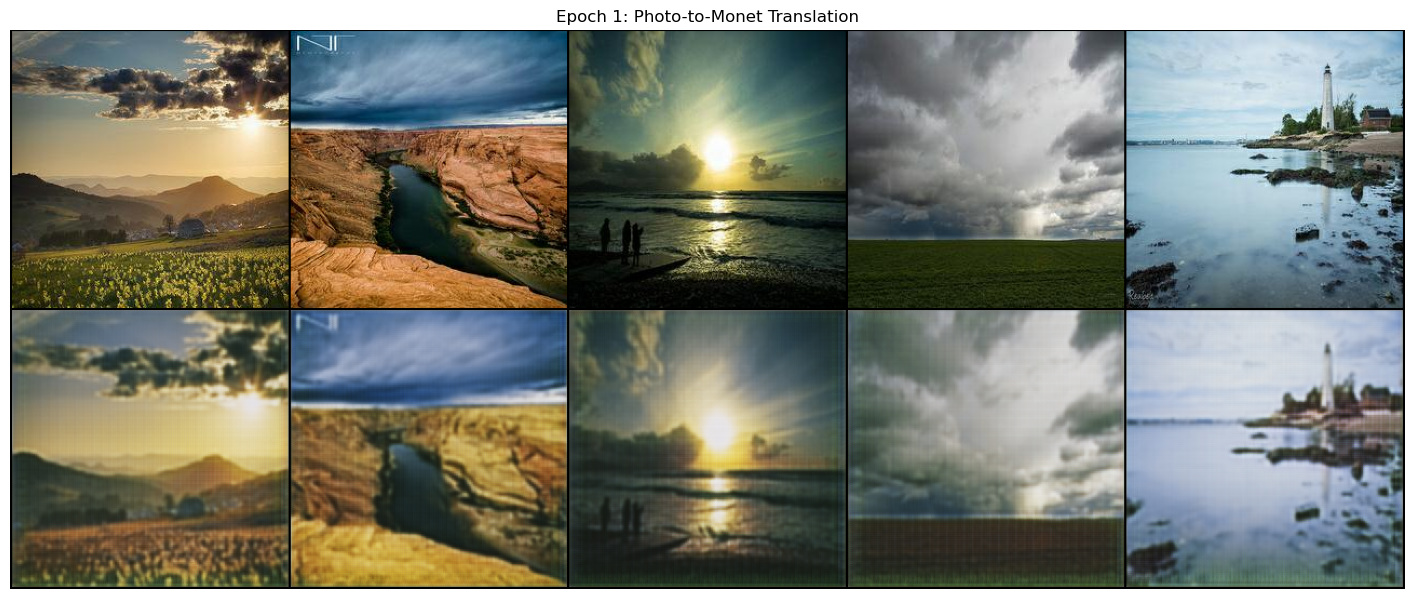

Epoch 10 - gen_loss_PM: 2.38413 - gen_loss_MP: 2.31762 - disc_loss_M: 0.62777 - disc_loss_P: 0.63274


In [14]:
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    logger=False,
    enable_checkpointing=False,
    max_epochs=NUM_EPOCHS,
)

dm = CustomDataModule()
model = CycleGAN()
trainer.fit(model, datamodule=dm)

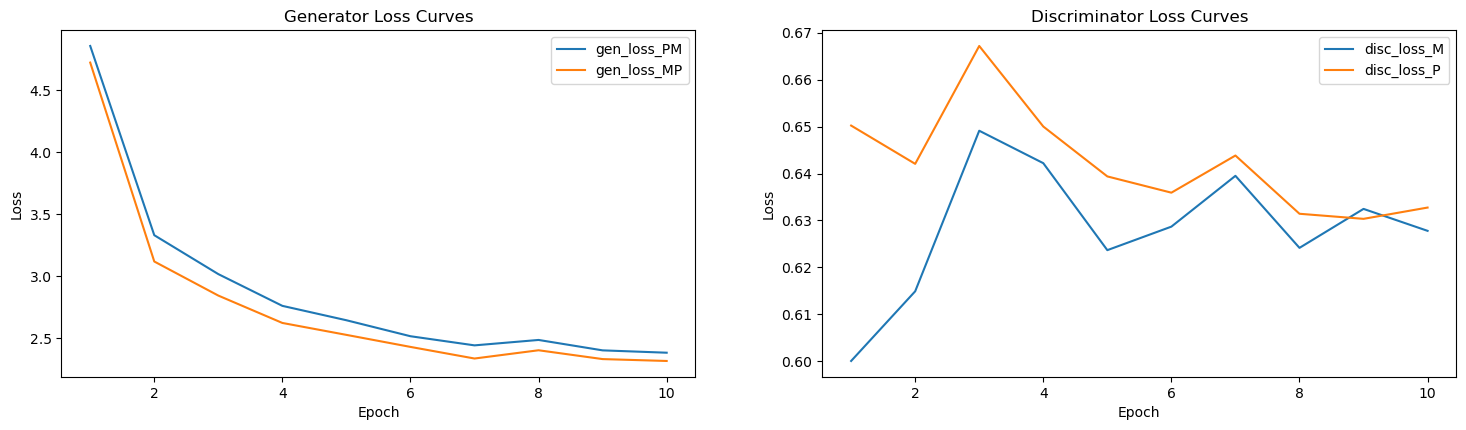

In [15]:
model.loss_curves()